# InCURA Tutorial - Recover gene signatures in cluster

## Follow this tutorial when you have one or multiple gene signatures and you would like to check whether they are enriched in the InCURA clusters. 


### Import of packages

In [26]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import scanpy as sc
import scipy.cluster.hierarchy as sch
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import re
from datetime import datetime

# Needed for some plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Create a timestamp string
timestamp = datetime.now().strftime("%Y%m%d")

pd.set_option('display.max_rows', 500)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
custom_colors = ['#e8ba41', '#b1a73e', '#b93c6d', '#b4d6e7', 'grey']

### Load data

In [2]:
# Set path variable
path = 'tutorial_data/'

In [4]:
cluster0 = pd.read_csv(path + 'Count_cluster0_genes_k4.tsv', sep='\t')
cluster1 = pd.read_csv(path + 'Count_cluster1_genes_k4.tsv', sep='\t')
cluster2 = pd.read_csv(path + 'Count_cluster2_genes_k4.tsv', sep='\t')
cluster3 = pd.read_csv(path + 'Count_cluster3_genes_k4.tsv', sep='\t')

### Check for enrichment of gene signatures in the resulting InCURA clusters.
#### For demonstration we use the markers for CD11chi B cells from the human SLE dataset ([Wang et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29717110/)) that we included as a case study.

In [5]:
Teff_genes = ['Klrg1', 'Clnk', 'Gzma', 'Zeb2', 'Cxcr1', 'Fasl', 'Prf1', 'Ccr5', 'Havcr2', 'Ly6c2', 'Ifng', 'Gzmk', 'Nr4a1', 'Gzmb', 'Ccl3']
Tex_genes = ['Myb', 'Trib2', 'Cxcr6', 'Pdcd1', 'Il7r', 'Lef1', 'Cxcr3', 'Cd160', 'Baz2b', 'Bach2', 'Slamf6', 'Cxcr5', 'Sell', 'Tcf7', 'Tox2', 'Ccr7', 'Ikzf2', 'Ccr6']

In [24]:
# Assuming df1, df2, df3, df4 are your four cluster DataFrames
dfs = {'Cluster 0': cluster0, 'Cluster 1': cluster1, 'Cluster 2': cluster2, 'Cluster 3': cluster3}

# List of marker genes
marker_genes = set(Teff_genes)  # Replace with your marker genes
all_genes = set(pd.concat(dfs.values())['symbols'])  # All genes across all clusters

# Perform enrichment test for each cluster
results = []
for cluster, df in dfs.items():
    cluster_genes = set(df['symbols'])  # Genes in this cluster

    # Define contingency table
    a = len(cluster_genes & marker_genes)       # Marker genes in cluster
    b = len(cluster_genes - marker_genes)       # Non-marker genes in cluster
    c = len(marker_genes - cluster_genes)       # Marker genes not in cluster
    d = len(all_genes - cluster_genes - marker_genes)  # Non-marker genes not in cluster

    # Fisher's exact test
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative="greater")
    
    results.append({"Cluster": cluster, "Marker Genes in Cluster": a, 
                    "p-value": p_value, "Odds Ratio": odds_ratio})

# Convert results to DataFrame
df_Teff = pd.DataFrame(results).sort_values("Cluster")

In [25]:
# Assuming df1, df2, df3, df4 are your four cluster DataFrames
dfs = {'Cluster 0': cluster0, 'Cluster 1': cluster1, 'Cluster 2': cluster2, 'Cluster 3': cluster3}

# List of marker genes
marker_genes = set(Tex_genes)  # Replace with your marker genes
all_genes = set(pd.concat(dfs.values())['symbols'])  # All genes across all clusters

# Perform enrichment test for each cluster
results = []
for cluster, df in dfs.items():
    cluster_genes = set(df['symbols'])  # Genes in this cluster

    # Define contingency table
    a = len(cluster_genes & marker_genes)       # Marker genes in cluster
    b = len(cluster_genes - marker_genes)       # Non-marker genes in cluster
    c = len(marker_genes - cluster_genes)       # Marker genes not in cluster
    d = len(all_genes - cluster_genes - marker_genes)  # Non-marker genes not in cluster

    # Fisher's exact test
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative="greater")
    
    results.append({"Cluster": cluster, "Marker Genes in Cluster": a, 
                    "p-value": p_value, "Odds Ratio": odds_ratio})

# Convert results to DataFrame
df_Tex = pd.DataFrame(results).sort_values("Cluster")

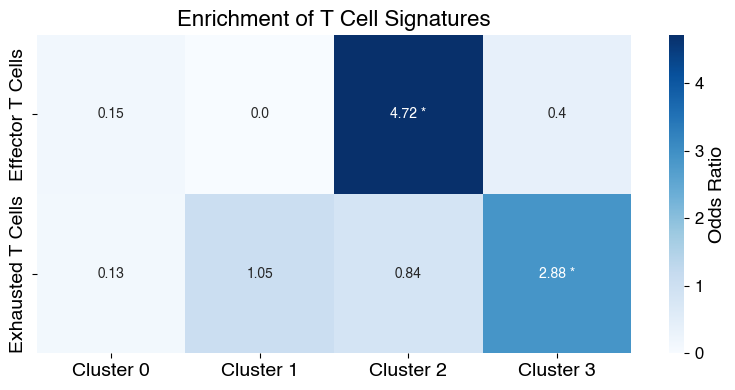

In [26]:
# Tag each dataframe with the corresponding signature name
df_Teff['Signature'] = 'Effector T Cells'
df_Tex['Signature'] = 'Exhausted T Cells'


# Combine all into one dataframe
df_all = pd.concat([df_Teff, df_Tex], ignore_index=True)


# Pivot into heatmap format: rows = signature, columns = cluster
heatmap_data = df_all.pivot(index='Signature', columns='Cluster', values='Odds Ratio')

# Create a boolean mask for significant values (p ≤ 0.05)
df_all['significant'] = df_all['p-value'] <= 0.05

# Create annotations with asterisks for significant cells
annot_matrix = df_all.pivot(index='Signature', columns='Cluster', values='Odds Ratio').round(2).astype(str)
sig_mask = df_all.pivot(index='Signature', columns='Cluster', values='significant')

# Add '*' where significant
annot_matrix = annot_matrix.where(~sig_mask, annot_matrix + ' *')

# Plot heatmap
plt.figure(figsize=(8, 4))
ax = sns.heatmap(heatmap_data, annot=annot_matrix, fmt="", cmap="Blues", cbar_kws={'label': 'Odds Ratio'})

# Customize colorbar font sizes
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)               # Tick label font size
colorbar.ax.set_ylabel('Odds Ratio', fontsize=14)

plt.title("Enrichment of T Cell Signatures", fontsize=16)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(path + f'enrichment_heatmap_per_cluster_odds_k5_{timestamp}.svg', bbox_inches='tight')
plt.show()